In [17]:
import matplotlib.pyplot as plt
import numpy as np
from image_generation import generate_test_image, mycomputeColor
from conjugate_gradient import cg_main, OF_cg
from multigrid import multigrid_main, V_cycle
from preprocessing import calculate_image_derivatives, preprocess_image, get_rhs


# Theoretical questions

The system (5) can be written as a problem on the form $Ax=b$, equivalently

$$
\begin{bmatrix}
D_{xx} + \lambda A_{1,1} & D_{xy} \\
D_{xy} & D_{2,2} + \lambda A_{2,2}
\end{bmatrix}
\begin{bmatrix}
u \\
v
\end{bmatrix}
=
b.
$$

All matrices and vectors are of dimensions

$$
D_{xx},\, D_{xy},\, D_{yy},\, A_{1,1}, A_{2,2} \in \mathbb{R}^{(m n) \times (m n)}, \qquad
u,\, v \in \mathbb{R}^{m n}, \qquad
b \in \mathbb{R}^{2 m n}.
$$ 

Rhe diagonal matrices are

$$
(D_{xx})_{i,j} =
\begin{cases}
0, & i \ne j, \\[6pt]
(I_x)_{i,i}^2, & i = j,
\end{cases}
\qquad\text{where}\qquad
(I_x)_{i,i}
= \tfrac{1}{2} \Big( (I_0 - I_1)_{i+1,\,i} - (I_0 - I_1)_{i,\,i} \Big).
$$

$$
(D_{yy})_{i,j} =
\begin{cases}
0, & i \ne j, \\[6pt]
(I_y)_{i,i}^2, & i = j,
\end{cases}
\qquad\text{where}\qquad
(I_y)_{i,i}
= \tfrac{1}{2} \Big( (I_0 - I_1)_{i,\,i+1} - (I_0 - I_1)_{i,\,i} \Big).
$$


$$
(D_{xy})_{i,j} =
\begin{cases}
0, & i \ne j, \\[6pt]
(I_x)_{i,i}\,(I_y)_{i,i}, & i = j,
\end{cases}
\qquad\text{where}\qquad
\begin{aligned}
(I_x)_{i,i} &= \tfrac{1}{2} \Big( (I_0 - I_1)_{i+1,\,i} - (I_0 - I_1)_{i,\,i} \Big), \\[4pt]
(I_y)_{i,i} &= \tfrac{1}{2} \Big( (I_0 - I_1)_{i,\,i+1} - (I_0 - I_1)_{i,\,i} \Big).
\end{aligned}
$$

Depending on what boundary condition we use we get two slightly different laplace discretizations. For Dirichlet B.C we get

$$
(A_{1,1}^{dir})_{ij} = (A_{2,2}^{dir})_{ij} =
\begin{cases}
4, & \text{if } i=j,\\
-1, & \text{if } |i-j|=1,\\
-1, & \text{if } |i-j|=m,\\
0, & \text{otherwise.}
\end{cases}
$$

$$
A_{1,1}^{dir} = A_{2,2}^{dir} = 
\begin{bmatrix}
4 & -1 &        &        & \cdots &        & -1     &        &        \\
-1& 4  & -1     &        &        & \cdots &        & -1     &        \\
   & -1 & 4     & -1     &        &        & \cdots &        & \ddots \\
   &    & \ddots& \ddots & \ddots &        &        &        &        \\
\vdots&  &       & -1     & 4     & -1     &        &        &        \\
      & \vdots  &        &        & -1     & 4      & -1     &        &        \\
-1    &         & \cdots &        &        & -1     & 4      & -1     &        \\
      & -1      &        & \cdots &        &        & -1     & 4      & -1     \\
      &         & \ddots &        &        &        &        & -1     & 4
\end{bmatrix}.
$$

Using Neumann B.C we get the same matrix as with Dirichlet, but with different diagonal entries

$$
(A_{1,1}^{neu})_{ij} = (A_{2,2}^{neu})_{ij} =
\begin{cases}
-1, & \text{if } |i-j|=1 \text{ (horizontal neighbor)},\\[4pt]
-1, & \text{if } |i-j|=m \text{ (vertical neighbor)},\\[4pt]
d_i, & \text{if } i=j,\\[4pt]
0, & \text{otherwise,}
\end{cases}
$$

where the diagonal value depends on how many neighbors the point has

$$
d_i =
\begin{cases}
2, & i \in \{\,1,\ m,\ m(n-1)+1,\ mn\,\}, \\[6pt]
3, & i \in \{\,2,\dots,m-1\,\}
      \;\cup\; \{\,k m + 1 : k=1,\dots,n-2\,\}
      \;\cup\; \{\,m(n-1)+2,\dots,mn-1\,\}
      \;\cup\; \{\,m k : k=2,\dots,n-1\,\}, \\[6pt]
4, & \text{otherwise.}
\end{cases}
$$

Finally we have

$$
b_j =
\begin{cases}
-\,(I_t)_j\,(I_x)_{j,j}, & 1 \le j \le mn,\\[6pt]
-\,(I_t)_{j-mn}\,(I_y)_{j-mn,\,j-mn}, & mn < j \le 2mn.
\end{cases}
$$


## Properties of the linear system

First we check wether the system is symmetric. 

$$
A^T 
=
 \begin{bmatrix}
D_{xx} + \lambda A_{1,1} & D_{xy} \\
D_{xy} & D_{yy} + \lambda A_{2,2}
\end{bmatrix}^T
= 
\begin{bmatrix}
D_{xx}^T + \lambda A_{1,1}^T & D_{xy}^T \\
D_{xy}^T & D_{yy}^T + \lambda A_{2,2}^T
\end{bmatrix}
=
\begin{bmatrix}
D_{xx} + \lambda A_{1,1} & D_{xy} \\
D_{xy} & D_{yy} + \lambda A_{2,2}
\end{bmatrix} = A.
$$

Now we check wether the system is positive (semi-)definite. To do this we do the split

$$
A = \lambda A_1 + A_2 = 
\lambda 
\begin{bmatrix}
 A_{1,1} & 0 \\
 0 & A_{2,2}
\end{bmatrix}
+
\begin{bmatrix}
D_{xx}  & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}.
$$

Firstly we consider with Dirichlet B.C. When looking at the Gershgorin disks of $A_1^{dir}$ we see that all diagonal entries has the value $a_{ii}=4$, thus all disk centres are at the same point. There are three possibilities for radiuses, that is $r_i\in\{2,3,4\}$. 

If a eigenvalue is on the boundary of the union of a set of connected Gershgorin disks, then it is on the boundary of all the gershgorin disks in the connected union. Since only a subset of the disks hit zero, the eigenvalues cannot be zero. Thus all eigenvalues are strictly positive. As $A_1^{dir}$ is symmetric and all eigenvaleus are strictly positive, it is positive definite.

Secondly, we look at the Neumann B.C. We see that $a_ii=r_i$ where $a_{ii} \in\{2,3,4\}$. Here we see that the boundary of all the disks intersect at zero. Thus we can only guarantee positive semi-definiteness.

The Figure below shows the corresponding Gershgorin disks for both scenarios.

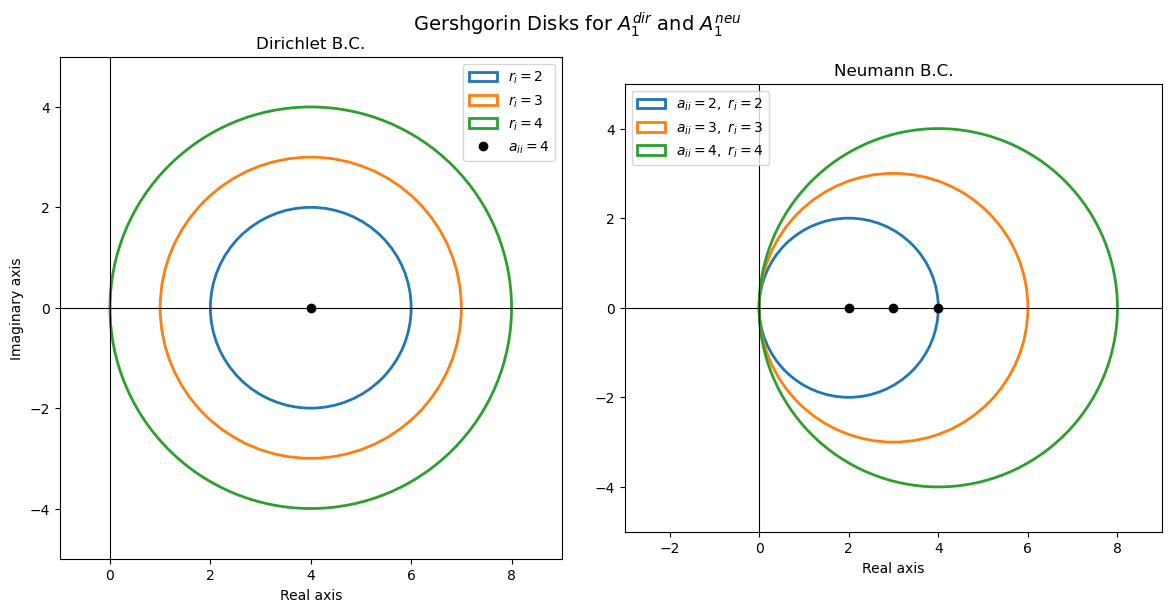

In [18]:
# --- Dirichlet setup ---
center_dir = 4
radii_dir = [2, 3, 4]
colors_dir = ['tab:blue', 'tab:orange', 'tab:green']

# --- Neumann setup ---
# Centers depend on a_ii = {2, 3, 4}, radii equal to those values
centers_neu = [2, 3, 4]
radii_neu = [2, 3, 4]
colors_neu = ['tab:blue', 'tab:orange', 'tab:green']

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# === Dirichlet plot ===
ax = axes[0]
for r, c in zip(radii_dir, colors_dir):
    circle = plt.Circle((center_dir, 0), r, color=c, fill=False, lw=2, label=fr"$r_i={r}$")
    ax.add_patch(circle)

ax.plot(center_dir, 0, 'ko', label=r"$a_{ii}=4$")
ax.axhline(0, color='black', lw=0.8)
ax.axvline(0, color='black', lw=0.8)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1, 9)
ax.set_ylim(-5, 5)
ax.set_title("Dirichlet B.C.")
ax.set_xlabel("Real axis")
ax.set_ylabel("Imaginary axis")
ax.legend()

# === Neumann plot ===
ax = axes[1]
for cen, r, c in zip(centers_neu, radii_neu, colors_neu):
    circle = plt.Circle((cen, 0), r, color=c, fill=False, lw=2, label=fr"$a_{{ii}}={cen},\ r_i={r}$")
    ax.add_patch(circle)

ax.plot(centers_neu, [0]*len(centers_neu), 'ko')
ax.axhline(0, color='black', lw=0.8)
ax.axvline(0, color='black', lw=0.8)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-3, 9)
ax.set_ylim(-5, 5)
ax.set_title("Neumann B.C.")
ax.set_xlabel("Real axis")
ax.legend()

# --- Global figure title ---
fig.suptitle("Gershgorin Disks for $A_1^{dir}$ and $A_1^{neu}$", fontsize=14)
plt.tight_layout()
plt.show()

Now we look at $A_2$. This matrix is the same for both B.C.s For this matrix to be some type of diagonally dominant we need $(I_x)_i^2 \geq |(I_x)_i(I_y)_i|$ and $(I_y)_i^2 \geq |(I_x)_i(I_y)_i|$ for all $i=1,...,mn$. This is only true if $|(I_x)_i|=|(I_x)_i|$, wich is generally not true. However, this does not discard positive (semi-)definiteness.

For any $x\in \mathbb{R}^{2mn}$,

$$
x^T
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{yx} & D_{yy}
\end{bmatrix}
x
=
\begin{bmatrix}
u^\top & v^\top
\end{bmatrix}
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{yx} & D_{yy}
\end{bmatrix}
\begin{bmatrix}
u \\[3pt]
v
\end{bmatrix}
=
u^\top D_{xx} u 
+ u^\top D_{xy} v 
+ v^\top D_{yx} u 
+ v^\top D_{yy} v
=
\sum_{i=1}^{mn} (I_x)^2_i u_i^2 + 2 \sum_{i=1}^{mn}(I_x)_i(I_y)_i u_iv_i + \sum_{i=1}^{mn} (I_y)_i^2 v_i^2 = \sum_{i=1}^{mn} \Big( (I_x)_iu_i + (I_y)_i v_i \Big)^2 \geq 0.
$$




Knowing $A_1$ is positive definite and $A_2$ is positive semi-definite we get for any $x\in \mathbb{R}^{2mn}$

$$
x^TAx = x^T(\lambda A_1+A_2)x= \lambda x^TA_1x + x^TA_2x \geq \lambda x^TA_1x > 0.
$$

In conclusion the whole system is positive definite.

## Convergence results

When applying Dirichlet boundary conditions to (5), the resulting system matrix becomes symmetric and positive definite. In this case, the **Gauss-Seidel** method is guaranteed to converge for any initial guess, while the **Conjugate Gradient (CG)** method also converges and is the most efficient choice due to its suitability for symmetric positive definite systems. The **Jacobi** method, on the other hand, is generally much slower and not guaranteed to converge for all choices of parameters. It converges for the pure Laplacian but can fail for the full operator $A = \lambda A_1 + A_2$ if the additional terms in $A_2$ destroy diagonal dominance. In practice, Jacobi convergence depends on the spectral radius of the iteration matrix, and without strict diagonal dominance this condition may not hold.

For Neumann boundary conditions, the Laplacian part $A_1$ is only positive semi-definite, with a constant vector in its nullspace. If the image-dependent term $A_2$ removes this nullspace, the full operator becomes positive definite, and the same convergence properties apply as in the Dirichlet case: both **Gauss-Seidel** and **CG** converge, while **Jacobi** remains conditionally convergent. However, if the constant mode is not removed and the system remains singular, none of the iterative methods are guaranteed to converge. In such cases, one must either regularize the system slightly or constrain the solution space (for instance by enforcing zero mean) to restore uniqueness and ensure convergence.


## Generate test images

In [19]:
n = 2**6
test_case_1 = generate_test_image(n, testcase=1)

## Conjugate gradient

In [20]:
reg = 1e-2

Ix, Iy, It = calculate_image_derivatives(test_case_1[0], test_case_1[1])
rhs_u, rhs_v = get_rhs(Ix, Iy, It)
u0 = np.zeros_like(rhs_u)
v0 = np.zeros_like(rhs_v)

u_cg, v_cg, res_cg, max_iter_cg = OF_cg(u0, v0, Ix, Iy, reg, rhs_u, rhs_v, tol=1e-8, maxit=2000)

ValueError: not enough values to unpack (expected 4, got 3)

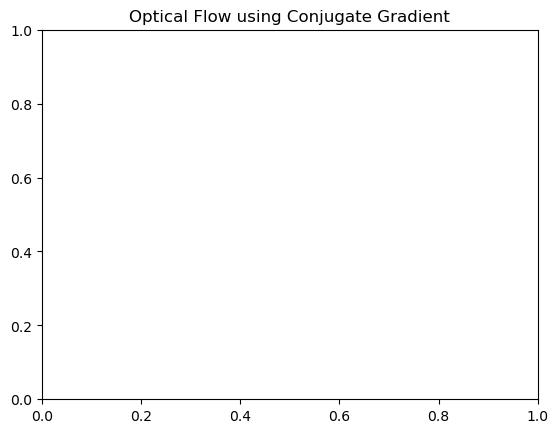

In [ ]:
mycomputeColor(u_cg, v_cg)
plt.title("Optical Flow using Conjugate Gradient")
plt.show()

print(f"CG converged in {max_iter_cg} iterations with residual norm {res_cg:.2e}")

